# Plots and Tables

This notebook creates plots and tables

## Imports

Import relevant packages

In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from os import path, makedirs
from scipy.stats import wilcoxon, shapiro, normaltest, ttest_rel
import numpy as np

## Ordering

Setup the ordering of categories for the tables in the report.

In [ ]:
orders = {
    "Edit Style": CategoricalDtype(categories=["Minimal", "Fluency"], ordered=True),
    "Metric": CategoricalDtype(
        categories=["GLEU", "ERRANT", "Scribendi Score", "SOME"], ordered=True
    ),
    "Submetric": CategoricalDtype(
        categories=[
            "-",
            "Precision",
            "Recall",
            "$\\text{F}_{0.5}$-Score",
            "Grammaticality",
            "Fluency",
            "Meaning Preservation",
            "Total",
        ],
        ordered=True,
    ),
    "System": CategoricalDtype(
        categories=["UAM-CSI", "Viking-7B", "Viking-13B"], ordered=True
    ),
}

## Read File

Read the raw CSV file into a pandas `DataFrame` and setup variables for holding category values.

In [ ]:
scores_csv_file = "scores_long.csv"
df = pd.read_csv(scores_csv_file)
df = df.fillna("-")

for col, dtype in orders.items():
    df[col] = df[col].astype(dtype)

df.sort_index(inplace=True)


columns = df.columns
essay_ids = df["Essay ID"].unique()
styles = df["Edit Style"].unique()
metrics = [
    tuple(row)
    for row in df[["Metric", "Submetric"]].drop_duplicates().to_numpy().tolist()
]
systems = df["System"].unique()

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]
['Minimal', 'Fluency']
Categories (2, object): ['Minimal' < 'Fluency']
[('GLEU', '-'), ('ERRANT', 'Precision'), ('ERRANT', 'Recall'), ('ERRANT', '$\\text{F}_{0.5}$-Score'), ('Scribendi Score', '-'), ('SOME', 'Grammaticality'), ('SOME', 'Fluency'), ('SOME', 'Meaning Preservation'), ('SOME', 'Total')]
['UAM-CSI', 'Viking-7B', 'Viking-13B']
Categories (3, object): ['UAM-CSI' < 'Viking-7B' < 'Viking-13B']
Orders
['GLEU', 'ERRANT', 'Scribendi Score', 'SOME']
Categories (4, object): ['GLEU' < 'ERRANT' < 'Scribendi Score' < 'SOME']
['-', 'Precision', 'Recall', '$\text{F}_{0.5}$-Score', 'Grammaticality', 'Fluency', 'Meaning Preservation', 'Total']
Categories (8, object): ['-' < 'Precision' < 'Recall' < '$\text{F}_{0.5}$-Score' < 'Grammaticality' < 'Fluency' < 'Meaning Preservation' < 'Total']


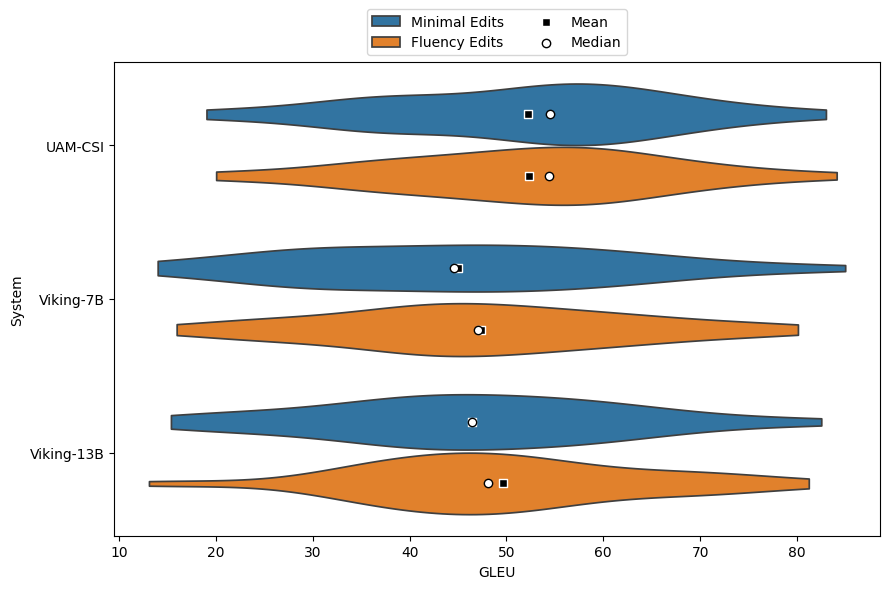

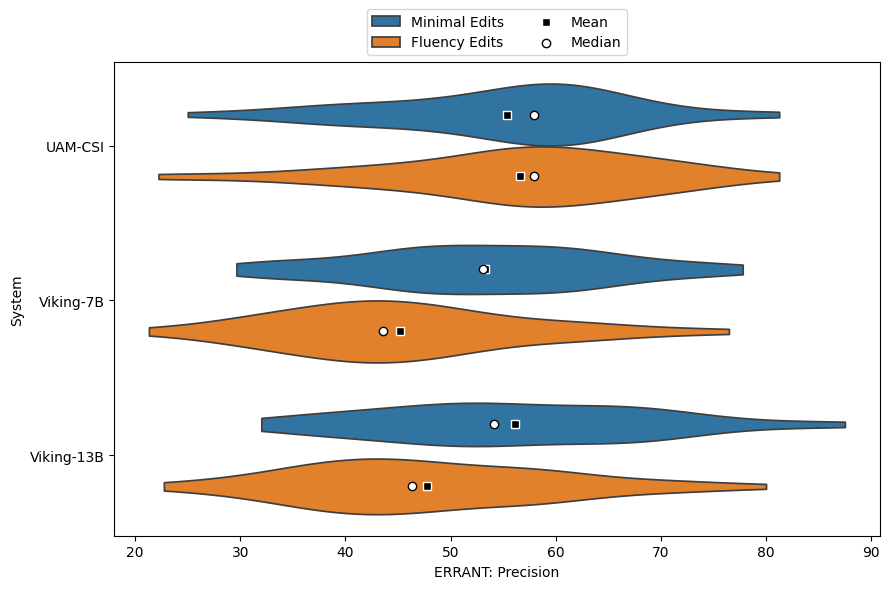

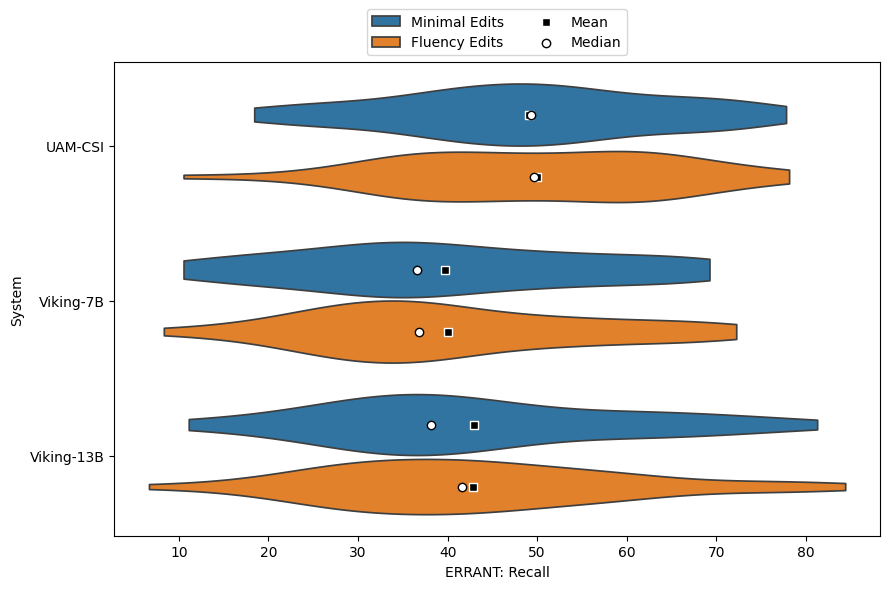

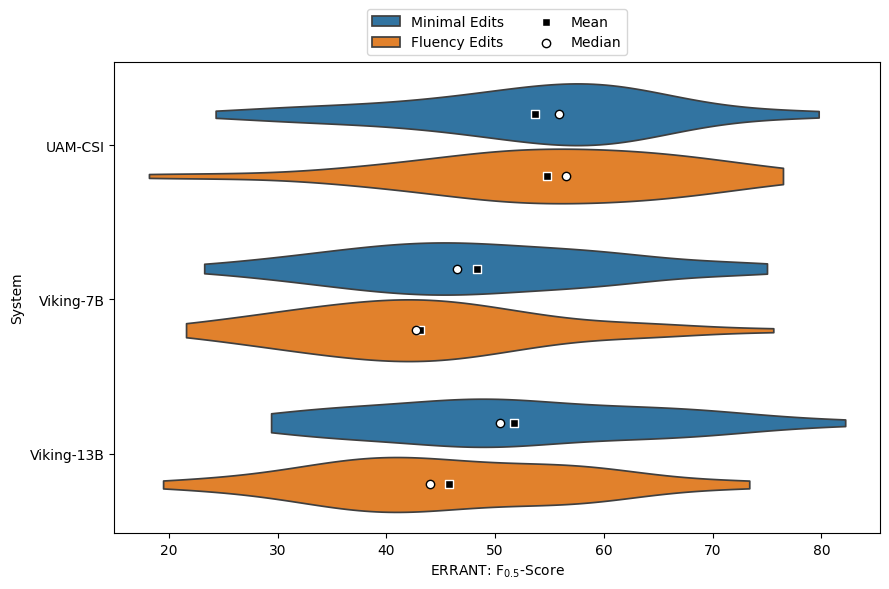

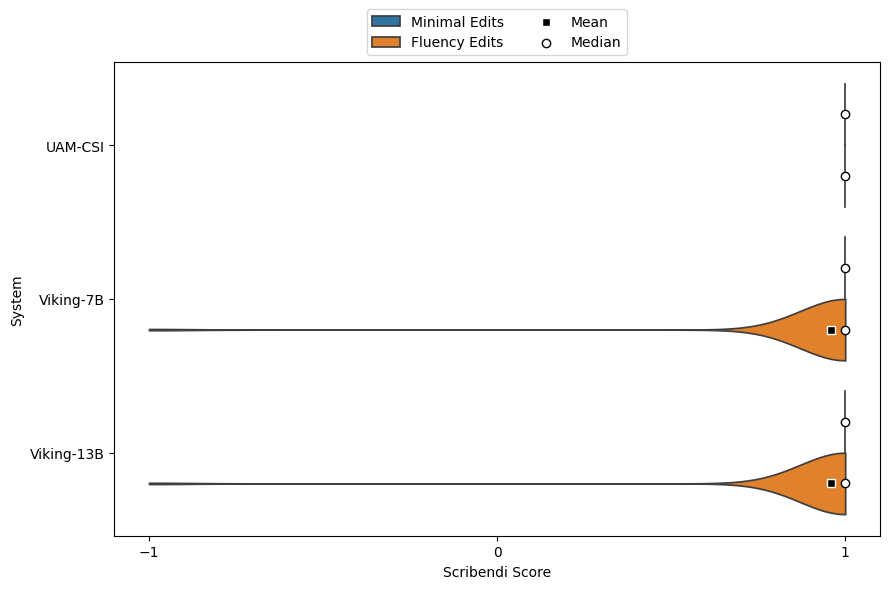

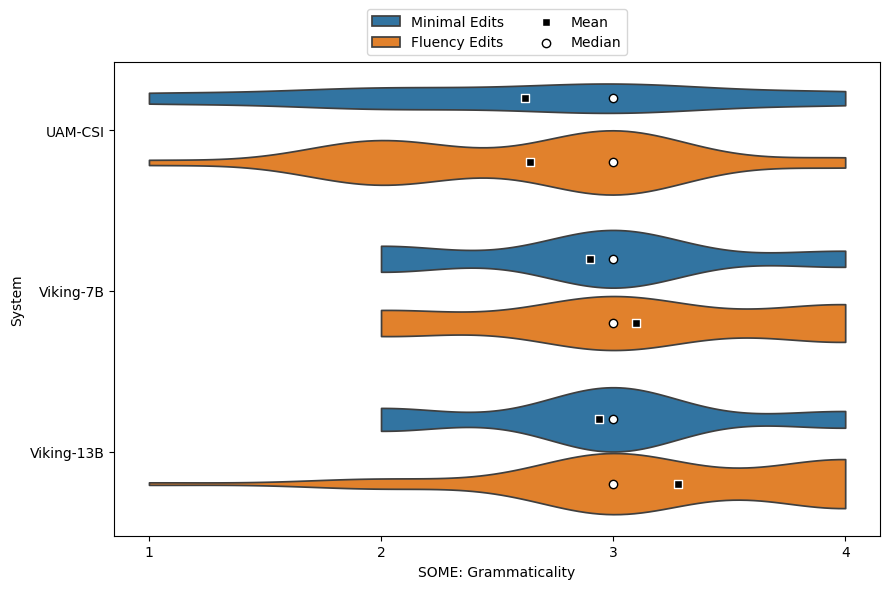

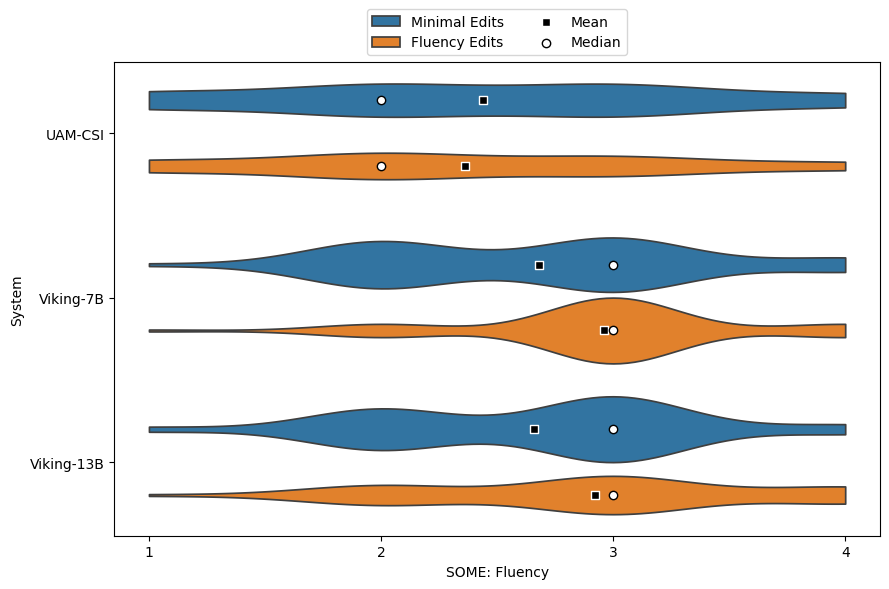

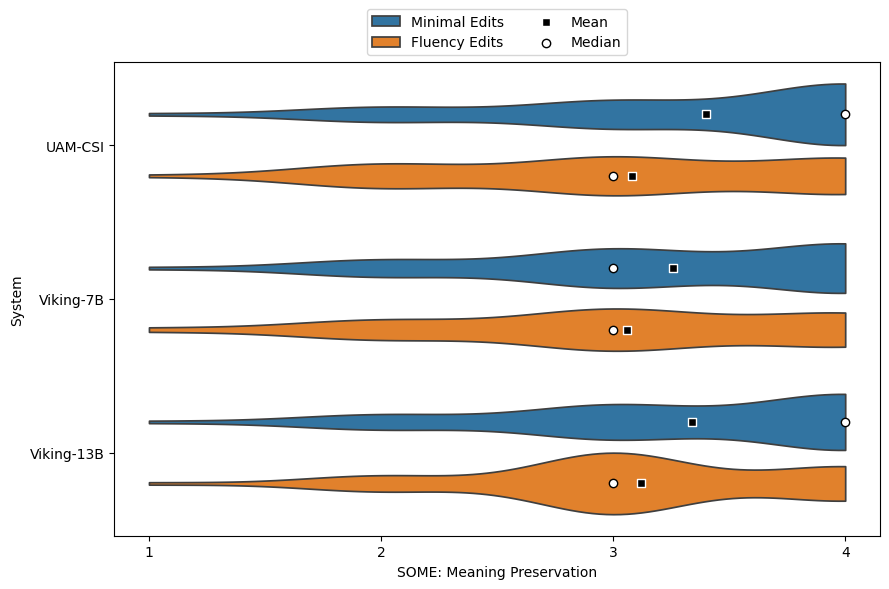

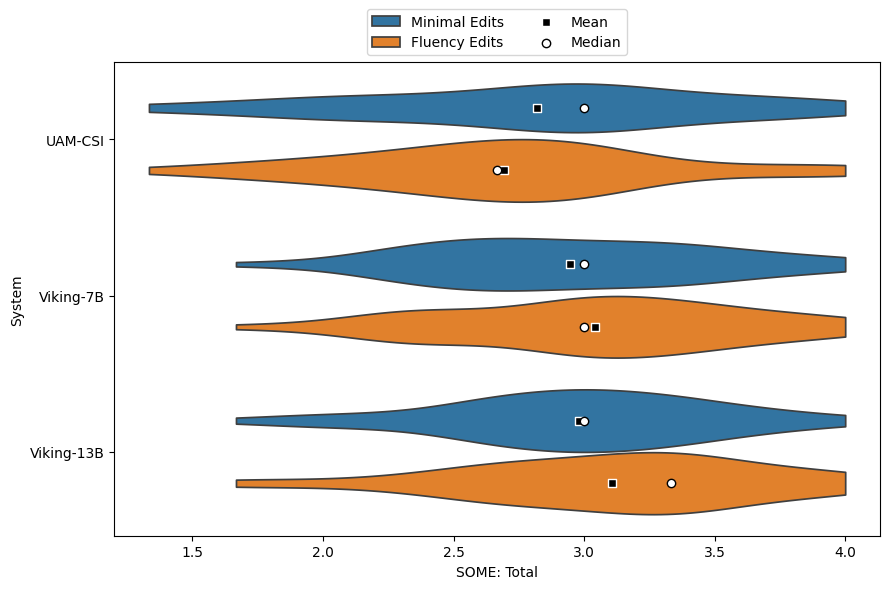

In [ ]:
def format_label(label):
    if label in metrics:
        major, minor = label
        if minor == "-":
            return major
        return f"{major}: {minor}"
    elif label in styles:
        return f"{label} Edits"
    return label


def normalize_metric(metric):
    match metric:
        case ("GLEU", "-"):
            return "gleu"
        case ("ERRANT", "Precision"):
            return "errant_precision"
        case ("ERRANT", "Recall"):
            return "errant_recall"
        case ("ERRANT", "$\\text{F}_{0.5}$-Score"):
            return "errant_f05"
        case ("Scribendi Score", "-"):
            return "scribendi_score"
        case ("SOME", "Grammaticality"):
            return "some_grammaticality"
        case ("SOME", "Fluency"):
            return "some_fluency"
        case ("SOME", "Meaning Preservation"):
            return "some_meaning_preservation"
        case ("SOME", "Total"):
            return "some_total"
        case _:
            raise ValueError(f"Unknown metric: {metric}")


def get_image_file_name(metric):
    normalized = normalize_metric(metric)
    return f"{normalized}.png"


def normalize_file_name(file_name):
    return file_name.lower().replace(".", "").replace(" ", "_")


plots_dir = "plots/"
makedirs(plots_dir, exist_ok=True)

metric_types = {
    "continuous": [
        ("GLEU", "-"),
        ("ERRANT", "Precision"),
        ("ERRANT", "Recall"),
        ("ERRANT", "$\\text{F}_{0.5}$-Score"),
        ("SOME", "Total"),
    ],
    "discrete": [
        ("Scribendi Score", "-"),
        ("SOME", "Grammaticality"),
        ("SOME", "Fluency"),
        ("SOME", "Meaning Preservation"),
    ],
}


def get_minmax(v):
    return v.min(), v.max()


def is_even(n):
    return n % 2 == 0


def get_metric_df(metric):
    major, minor = metric
    if pd.isna(minor):
        return df[df["Metric"] == major]
    return df[(df["Metric"] == major) & (df["Submetric"] == minor)]


offset = 0.2


for metric in metrics:

    metric_df = get_metric_df(metric)

    fig, ax = plt.subplots(figsize=(9, 6))
    sns.violinplot(
        metric_df,
        y="System",
        x="Score",
        cut=0,
        hue="Edit Style",
        inner=None,
        density_norm="area",
    )
    grouped = metric_df.groupby(["System", "Edit Style"], observed=False)["Score"]
    means = grouped.mean()
    medians = grouped.median()

    ys = [i // 2 - offset if is_even(i) else i // 2 + offset for i in range(len(means))]
    plt.scatter(
        y=ys,
        x=means,
        marker="s",
        color="black",
        edgecolors="white",
        zorder=3,
        label="Mean",
    )
    plt.scatter(
        y=ys,
        x=medians,
        marker="o",
        color="white",
        edgecolors="black",
        zorder=3,
        label="Median",
    )

    # Ensure axes show integers for discrete metrics
    if metric in metric_types["discrete"]:
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    ax.set(xlabel=format_label(metric), ylabel="System")

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, map(format_label, labels))
    sns.move_legend(
        ax,
        "lower center",
        ncol=2,
        bbox_to_anchor=(0.5, 1),
        frameon=True,
    )
    file_name = get_image_file_name(metric)
    file_path = path.join(plots_dir, file_name)
    plt.tight_layout()
    plt.savefig(file_path)
    plt.tight_layout()
    plt.show()

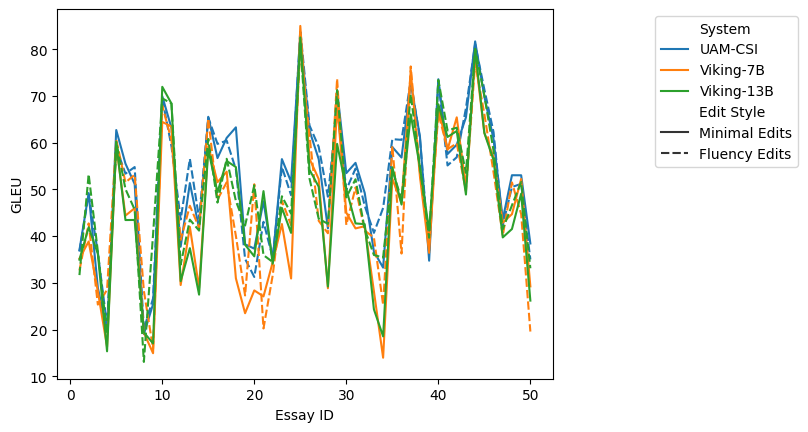

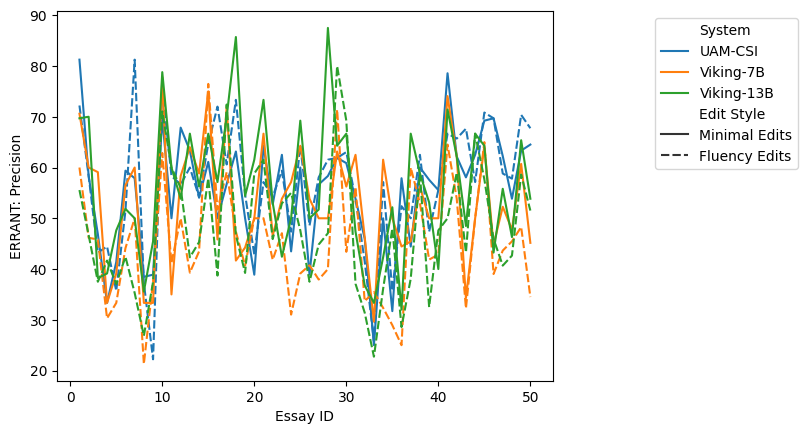

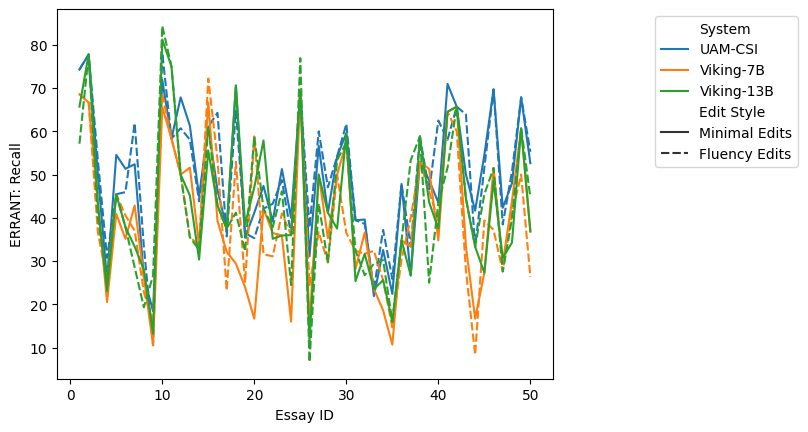

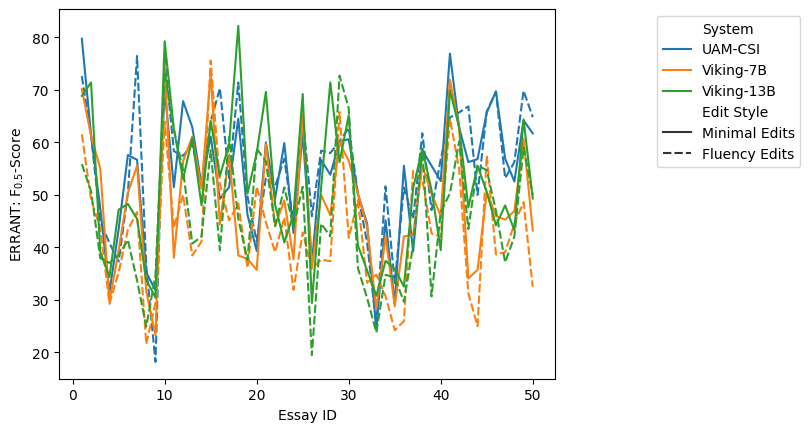

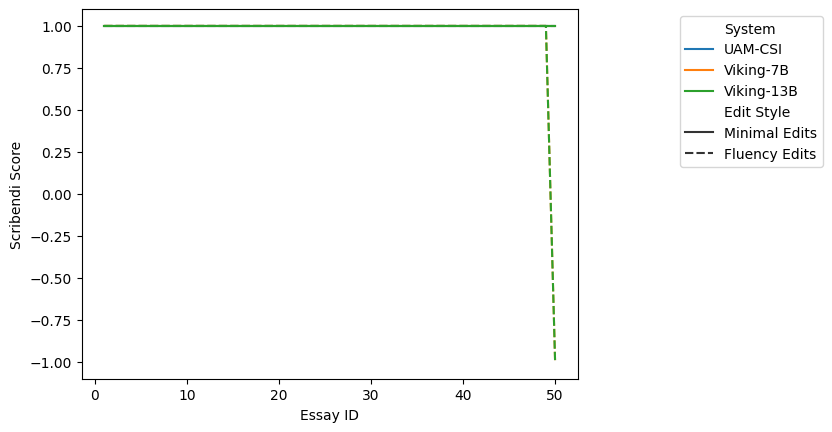

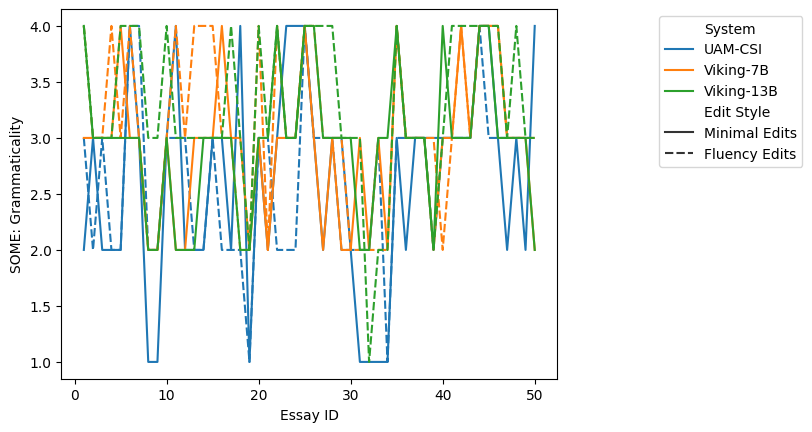

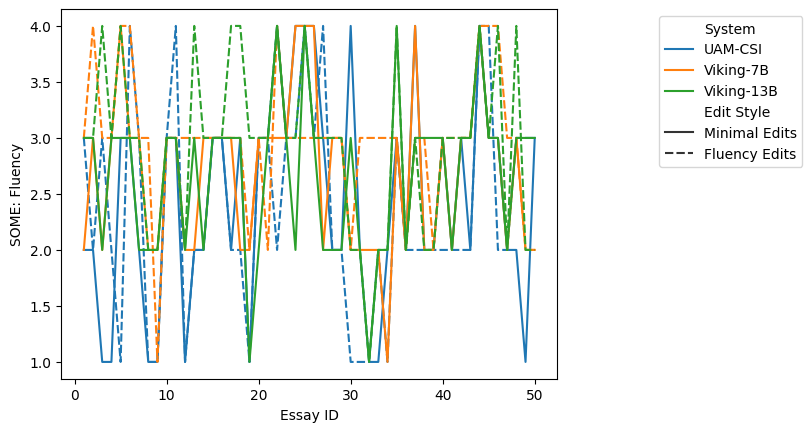

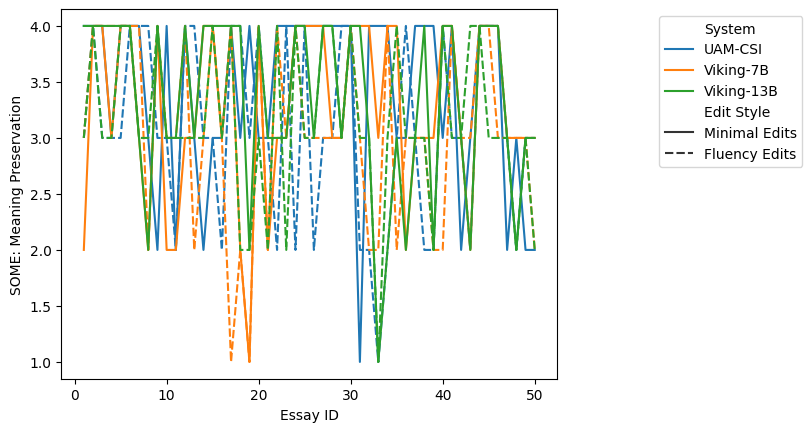

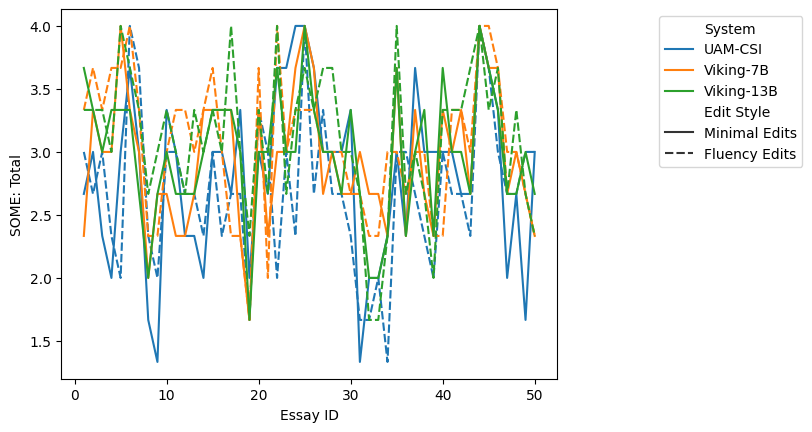

In [5]:
for metric in metrics:
    metric_df = get_metric_df(metric)

    ax = sns.lineplot(
        metric_df, x="Essay ID", y="Score", hue="System", style="Edit Style"
    )
    ax.set(xlabel="Essay ID", ylabel=format_label(metric))
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, map(format_label, labels))
    sns.move_legend(
        ax,
        "upper center",
        bbox_to_anchor=(1.35, 1),
        ncol=1,
        frameon=True,
    )
    plt.show()

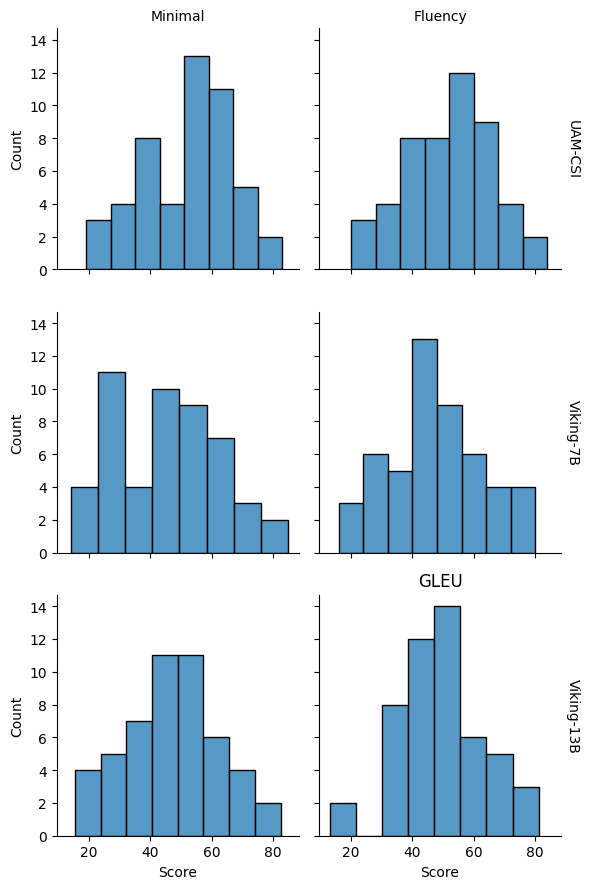

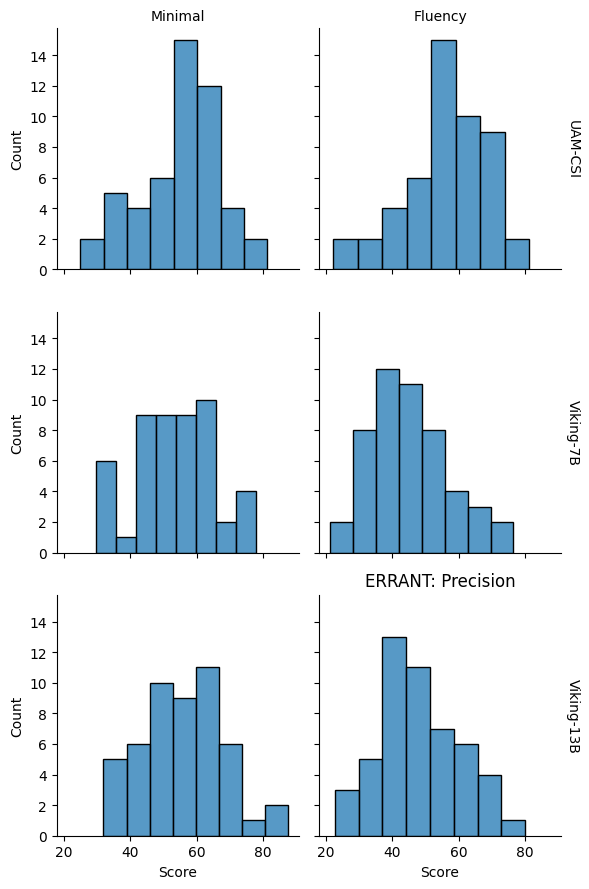

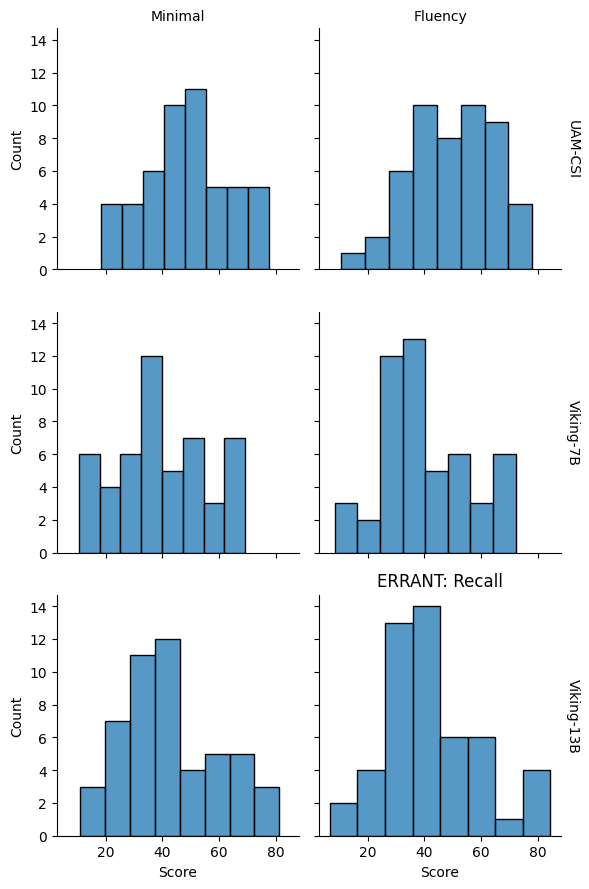

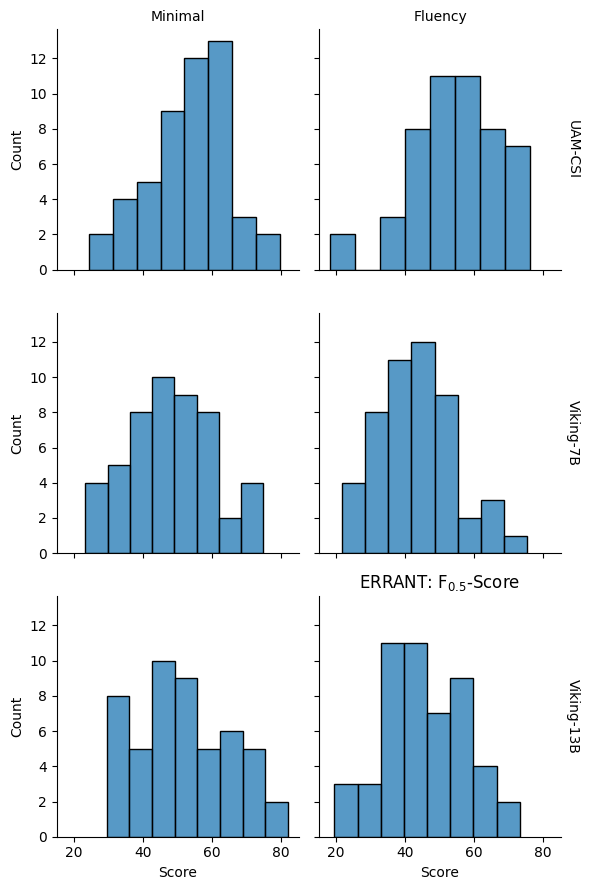

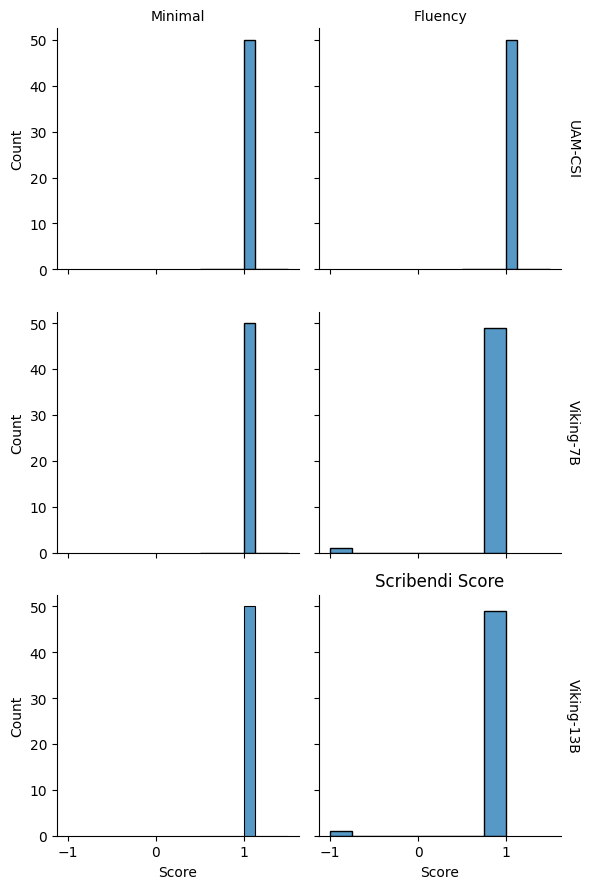

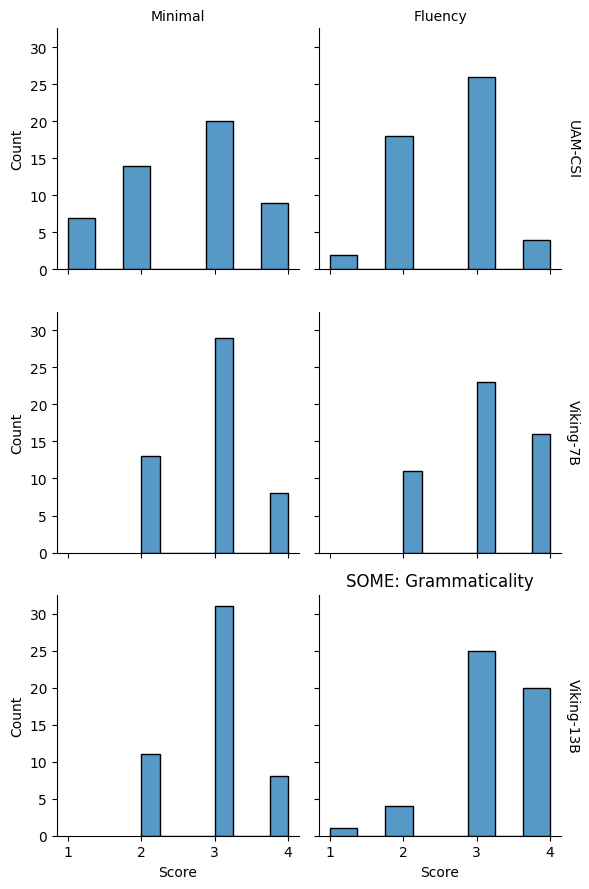

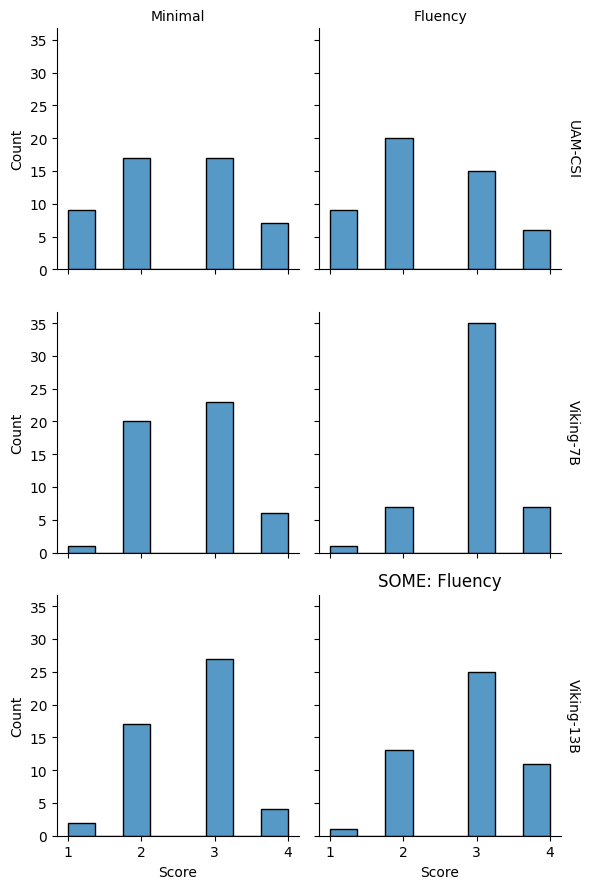

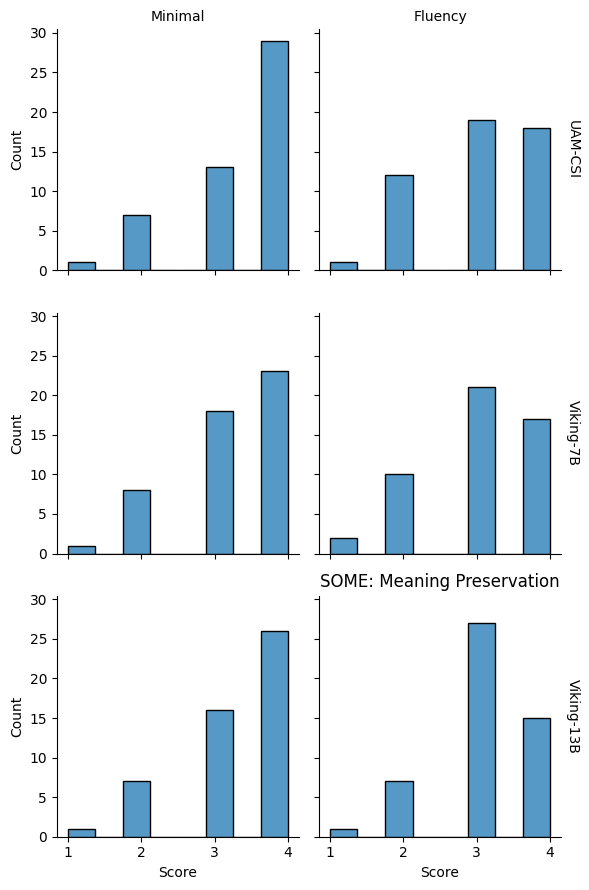

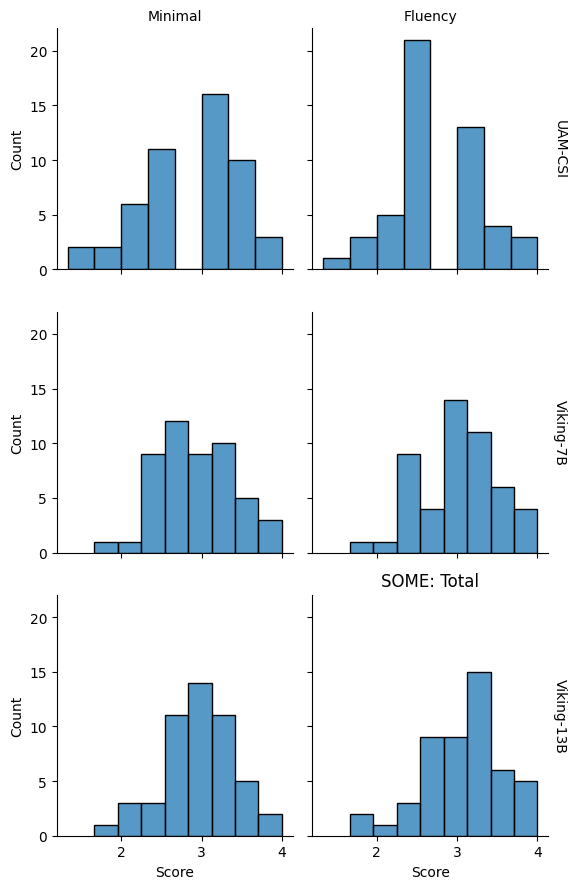

In [6]:
for metric in metrics:
    metric_df = get_metric_df(metric)
    g = sns.FacetGrid(
        metric_df,
        col="Edit Style",
        row="System",
        margin_titles=True,
        sharex=True,
        sharey=True,
    )
    g.map_dataframe(sns.histplot, x="Score", bins=8)

    # Set axis labels and titles
    g.set_axis_labels("Score", "Count")
    g.set_titles(row_template="{row_name}", col_template="{col_name}")

    plt.title(format_label(metric))

    plt.tight_layout()
    plt.show()

In [ ]:
def save_latex_table(latex, file_name):
    file_path = path.join(tables_dir, file_name)
    with open(file_path, "w+") as f:
        f.write(latex)


def get_spread(x):
    return x.max() - x.min()


def get_tex_file_name(metric):
    normalized = normalize_metric(metric)
    return f"{normalized}.tex"


continuous_metrics = [m for m in metrics if m in metric_types["continuous"]]

latex_args = {
    "sparse_index": True,
    "convert_css": True,
    "clines": "skip-last;data",
    "hrules": True,
    "column_format": None,
    "siunitx": True,
    "multicol_align": "c",
}


def float_formatter(x):
    return f"\\num{{{x:.2f}}}"


highlight = {
    "max": "background-color: kth-lightblue40",
    "min": "background-color: kth-lightred40",
}

tables_dir = "tables/"
makedirs(tables_dir, exist_ok=True)
summary_dir = path.join(tables_dir, "summary")
makedirs(summary_dir, exist_ok=True)

uparrow = r"$\uparrow$"
downarrow = r"$\downarrow$"
aggregated_column_names = {
    "mean": "mean" + uparrow,
    "median": "median" + uparrow,
    "min": "min" + uparrow,
    "max": "max" + uparrow,
    "spread": "spread" + downarrow,
}

for metric in continuous_metrics:
    metric_df = get_metric_df(metric)
    index = pd.MultiIndex.from_product(
        [
            metric_df["Edit Style"].unique(),
            metric_df["System"].unique(),
        ],
        names=["Edit Style", "System"],
    )
    summary = (
        metric_df.groupby(["Edit Style", "System"])
        .agg(
            mean=("Score", "mean"),
            median=("Score", "median"),
            min=("Score", "min"),
            max=("Score", "max"),
            spread=("Score", get_spread),
        )
        .reindex(index)
    )
    summary = summary.rename(columns=aggregated_column_names)
    print(metric)
    latex = (
        summary.style.highlight_min(props=highlight["min"], axis=0)
        .highlight_max(props=highlight["max"], axis=0)
        .format(formatter=float_formatter)
        .to_latex(
            **latex_args,
        )
    )

    print(latex)
    file_name = get_tex_file_name(metric)
    save_latex_table(latex, file_name)

('GLEU', '-')
\begin{tabular}{llSSSSS}
\toprule
{} & {} & {mean} & {median} & {min} & {max} & {spread} \\
{Edit Style} & {System} & {} & {} & {} & {} & {} \\
\midrule
\multirow[c]{3}{*}{Minimal} & UAM-CSI & \num{52.19} & {\cellcolor{kth-lightblue40}} \num{54.49} & \num{19.02} & \num{82.99} & {\cellcolor{kth-lightred40}} \num{63.97} \\
 & Viking-7B & {\cellcolor{kth-lightred40}} \num{44.96} & {\cellcolor{kth-lightred40}} \num{44.55} & \num{13.98} & {\cellcolor{kth-lightblue40}} \num{84.98} & {\cellcolor{kth-lightblue40}} \num{71.00} \\
 & Viking-13B & \num{46.48} & \num{46.39} & \num{15.35} & \num{82.51} & \num{67.16} \\
\cline{1-7}
\multirow[c]{3}{*}{Fluency} & UAM-CSI & {\cellcolor{kth-lightblue40}} \num{52.32} & \num{54.37} & {\cellcolor{kth-lightblue40}} \num{20.02} & \num{84.10} & \num{64.08} \\
 & Viking-7B & \num{47.39} & \num{47.02} & \num{15.94} & {\cellcolor{kth-lightred40}} \num{80.10} & \num{64.16} \\
 & Viking-13B & \num{49.61} & \num{48.05} & {\cellcolor{kth-lightred40}} \

/tmp/ipykernel_177502/3768749150.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  metric_df.groupby(["Edit Style", "System"])
/tmp/ipykernel_177502/3768749150.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  metric_df.groupby(["Edit Style", "System"])
/tmp/ipykernel_177502/3768749150.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  metric_df.groupby(["Edit Style", "System"])
/tmp/ipykernel_177502/3768749150.p

In [8]:
discrete_metrics = [m for m in metrics if m in metric_types["discrete"]]


def int_formatter(x):
    return f"\\num{{{x}}}"


for metric in discrete_metrics:
    print(metric)
    metric_df = get_metric_df(metric)

    scores = metric_df.groupby(["Edit Style", "System"], observed=False)["Score"]
    mean = scores.mean()
    median = scores.median()

    summary = metric_df.pivot_table(
        index=["Edit Style", "System"],
        columns="Score",
        aggfunc="size",
        fill_value=0,
        observed=False,
    )

    summary["mean"] = mean
    summary["median"] = median
    columns = ["mean", "median"] + list(summary.columns[:-2])
    summary = summary[columns]

    summary.columns = pd.MultiIndex.from_tuples(
        [
            ("", col) if col in ["mean", "median"] else ("Score Count", int(col))
            for col in summary.columns
        ]
    )

    latex = (
        summary.style.highlight_min(props=highlight["min"], axis=0)
        .highlight_max(props=highlight["max"], axis=0)
        .format(formatter=float_formatter, subset=[("", "mean"), ("", "median")])
        .format(formatter=int_formatter, subset=["Score Count"])
        .to_latex(
            **latex_args,
        )
    )

    file_name = get_tex_file_name(metric)
    save_latex_table(latex, file_name)

    print(latex)

('Scribendi Score', '-')
\begin{tabular}{llSSSS}
\toprule
{} & {} & \multicolumn{2}{c}{} & \multicolumn{2}{c}{Score Count} \\
{} & {} & {mean} & {median} & {-1} & {1} \\
{Edit Style} & {System} & {} & {} & {} & {} \\
\midrule
\multirow[c]{3}{*}{Minimal} & UAM-CSI & {\cellcolor{kth-lightblue40}} \num{1.00} & {\cellcolor{kth-lightred40}} {\cellcolor{kth-lightblue40}} \num{1.00} & {\cellcolor{kth-lightred40}} \num{0} & {\cellcolor{kth-lightblue40}} \num{50} \\
 & Viking-7B & {\cellcolor{kth-lightblue40}} \num{1.00} & {\cellcolor{kth-lightred40}} {\cellcolor{kth-lightblue40}} \num{1.00} & {\cellcolor{kth-lightred40}} \num{0} & {\cellcolor{kth-lightblue40}} \num{50} \\
 & Viking-13B & {\cellcolor{kth-lightblue40}} \num{1.00} & {\cellcolor{kth-lightred40}} {\cellcolor{kth-lightblue40}} \num{1.00} & {\cellcolor{kth-lightred40}} \num{0} & {\cellcolor{kth-lightblue40}} \num{50} \\
\cline{1-6}
\multirow[c]{3}{*}{Fluency} & UAM-CSI & {\cellcolor{kth-lightblue40}} \num{1.00} & {\cellcolor{kth-ligh

In [9]:
metric_types["continuous"].remove(("SOME", "Total"))
metric_types["discrete"].append(("SOME", "Total"))

In [10]:
significance_level = 0.05

dists = []
# grouped = df_long.groupby(["system", "correction_style", "metric"], observed=False)

for metric in metric_types["continuous"]:
    metric_df = get_metric_df(metric)
    for team in systems:
        team_df = metric_df[metric_df["System"] == team]
        for style in styles:
            style_df = team_df[team_df["Edit Style"] == style]
            scores = style_df["Score"].to_numpy()
            # scores = grouped.get_group((team, style, metric))["score"].to_numpy()

            shapiro_stat, shapiro_p = shapiro(scores)
            normaltest_stat, normaltest_p = normaltest(scores)

            dists.append(
                {
                    "metric": format_label(metric),
                    "team": team,
                    "style": style,
                    # "shapiro_stat": shapiro_stat,
                    "sp": shapiro_p,
                    "sn": shapiro_p > significance_level,
                    # "normaltest_stat": normaltest_stat,
                    "np": normaltest_p,
                    "nn": normaltest_p > significance_level,
                }
            )

dist_df = pd.DataFrame(dists)
display(dist_df)

,metric,team,style,sp,sn,np,nn
0,GLEU,UAM-CSI,Minimal,0.537457,True,0.717056,True
1,GLEU,UAM-CSI,Fluency,0.901659,True,0.890217,True
2,GLEU,Viking-7B,Minimal,0.617159,True,0.622972,True
3,GLEU,Viking-7B,Fluency,0.732172,True,0.808066,True
4,GLEU,Viking-13B,Minimal,0.904409,True,0.961554,True
5,GLEU,Viking-13B,Fluency,0.512281,True,0.814185,True
6,ERRANT: Precision,UAM-CSI,Minimal,0.170091,True,0.329197,True
7,ERRANT: Precision,UAM-CSI,Fluency,0.191668,True,0.087576,True
8,ERRANT: Precision,Viking-7B,Minimal,0.561792,True,0.798274,True
9,ERRANT: Precision,Viking-7B,Fluency,0.508271,True,0.246715,True


In [11]:
baseline = "UAM-CSI"
vikings = [t for t in systems if t != baseline]


def get_alternate_hypothesis(hypothesis):
    def is_odd(n):
        return n % 2 != 0

    return "greater" if is_odd(hypothesis) else "less"


def format_hypothesis(hypothesis):
    return f"$H_{{{hypothesis}}}$"


def perform_statistical_test(metric, scores, alternative):
    if metric in metric_types["continuous"]:
        return ttest_rel(scores[0], scores[1], alternative=alternative)
    diffs = np.around(scores[0] - scores[1], 3)
    return wilcoxon(diffs, alternative=alternative)


grouped = df.groupby(["System", "Edit Style", "Metric", "Submetric"], observed=False)


def perform_statistical_tests(hypothesis):
    test_results = []

    for team in vikings:
        for metric in metrics:
            for style in styles:
                keys = [team, baseline]
                args = [(k, style, *metric) for k in keys]
                scores = [
                    grouped.get_group(arg)
                    .sort_values(by="Essay ID")["Score"]
                    .to_numpy()
                    for arg in args
                ]

                stat, p_value = perform_statistical_test(
                    metric, scores, get_alternate_hypothesis(hypothesis)
                )

                major, minor = metric
                test_results.append(
                    {
                        "System": team,
                        "Edit Style": style,
                        "Metric": major,
                        "Submetric": minor,
                        "statistic": stat,
                        "$p$-value": p_value,
                        "Hypothesis": format_hypothesis(hypothesis),
                    }
                )

    return test_results

## Test Multi Index

In [12]:
pos = perform_statistical_tests(1)
neg = perform_statistical_tests(2)
test_results = pos + neg
test_results_df = pd.DataFrame(test_results)
display(test_results_df)

/home/karl/kth/courses/da231x/da231x/evaluate/plot-env/lib/python3.13/site-packages/scipy/stats/_wilcoxon.py:172: RuntimeWarning: invalid value encountered in scalar divide
  z = (r_plus - mn) / se


,System,Edit Style,Metric,Submetric,statistic,$p$-value,Hypothesis
0,Viking-7B,Minimal,GLEU,-,-7.343150,1.000000,$H_{1}$
1,Viking-7B,Fluency,GLEU,-,-4.314411,0.999961,$H_{1}$
2,Viking-7B,Minimal,ERRANT,Precision,-1.469908,0.926011,$H_{1}$
3,Viking-7B,Fluency,ERRANT,Precision,-6.714196,1.000000,$H_{1}$
4,Viking-7B,Minimal,ERRANT,Recall,-7.402900,1.000000,$H_{1}$
...,...,...,...,...,...,...,...
67,Viking-13B,Fluency,SOME,Fluency,450.000000,0.999891,$H_{2}$
68,Viking-13B,Minimal,SOME,Meaning Preservation,213.500000,0.339505,$H_{2}$
69,Viking-13B,Fluency,SOME,Meaning Preservation,262.500000,0.620445,$H_{2}$
70,Viking-13B,Minimal,SOME,Total,405.500000,0.970598,$H_{2}$


In [13]:
def prepare_test_results(test_results_df, columns):
    # Select relevant columns and reset index
    df = test_results_df[columns]  # .reset_index(drop=True)

    pivot_index = [
        c for c in ["Metric", "Submetric", "Edit Style", "System"] if c in df.columns
    ]

    pivoted = df.pivot(index=pivot_index, columns=["Hypothesis"], values=["$p$-value"])

    pivoted_reset = pivoted.reset_index()
    pivoted_sorted = pivoted_reset.sort_values(
        by=pivot_index,
        key=lambda col: col if col.name not in orders else col.astype(orders[col.name]),
    )
    pivoted_sorted = pivoted_sorted.set_index(pivot_index)

    return pivoted_sorted


def generate_latex_table(df, latex_args, significance_level, green, formatter):
    return (
        df.style.map(lambda p: (green if float(p) < significance_level else ""))
        .format(formatter=formatter)
        .to_latex(**latex_args)
    )




def scientific_formatter(x):
    if pd.notnull(x):
        pretty = f"{x:.2e}"
        return f"\\num{{{pretty}}}"
    return f"\\text{{NaN}}"


# Define constants
columns = ["Metric", "Submetric", "Edit Style", "System", "$p$-value", "Hypothesis"]


# Prepare the test results DataFrame
renamed = prepare_test_results(test_results_df, columns)

# Generate the LaTeX table
green = "background-color: kth-lightgreen"
latex = generate_latex_table(
    renamed, latex_args, significance_level, green, scientific_formatter
)

# Save the LaTeX table to a file
file_name = "test_results.tex"
save_latex_table(latex, file_name)

print(latex)

\begin{tabular}{llllSS}
\toprule
{} & {} & {} & {} & \multicolumn{2}{c}{$p$-value} \\
{} & {} & {} & {Hypothesis} & {$H_{1}$} & {$H_{2}$} \\
{Metric} & {Submetric} & {Edit Style} & {System} & {} & {} \\
\midrule
\multirow[c]{4}{*}{GLEU} & \multirow[c]{4}{*}{-} & \multirow[c]{2}{*}{Minimal} & Viking-7B & \num{1.00e+00} & {\cellcolor{kth-lightgreen}} \num{9.77e-10} \\
 &  &  & Viking-13B & \num{1.00e+00} & {\cellcolor{kth-lightgreen}} \num{4.09e-09} \\
\cline{3-6}
 &  & \multirow[c]{2}{*}{Fluency} & Viking-7B & \num{1.00e+00} & {\cellcolor{kth-lightgreen}} \num{3.87e-05} \\
 &  &  & Viking-13B & \num{9.96e-01} & {\cellcolor{kth-lightgreen}} \num{3.86e-03} \\
\cline{1-6} \cline{2-6} \cline{3-6}
\multirow[c]{12}{*}{ERRANT} & \multirow[c]{4}{*}{Precision} & \multirow[c]{2}{*}{Minimal} & Viking-7B & \num{9.26e-01} & \num{7.40e-02} \\
 &  &  & Viking-13B & \num{3.18e-01} & \num{6.82e-01} \\
\cline{3-6}
 &  & \multirow[c]{2}{*}{Fluency} & Viking-7B & \num{1.00e+00} & {\cellcolor{kth-lightgreen

### Compare Viking-Based Systems

In [14]:
viking_results = []
for metric in metrics:
    major, minor = metric
    for style in styles:
        args = [(v, style, *metric) for v in vikings]
        scores = [
            grouped.get_group(arg).sort_values(by="Essay ID")["Score"].to_numpy()
            for arg in args
        ]
        """Explanation of the hypotheses:
        3: Viking-7B > Viking-13B
        4: Viking-7B < Viking-13B
        """
        hypotheses = [3, 4]
        for hypothesis in hypotheses:
            stat, p_value = perform_statistical_test(
                metric, scores, get_alternate_hypothesis(hypothesis)
            )
            viking_results.append(
                {
                    "Edit Style": style,
                    "Metric": major,
                    "Submetric": minor,
                    "statistic": stat,
                    "$p$-value": p_value,
                    "Hypothesis": format_hypothesis(hypothesis),
                }
            )

viking_results_df = pd.DataFrame(viking_results)
# Prepare the test results DataFrame
columns = ["Metric", "Submetric", "Edit Style", "$p$-value", "Hypothesis"]
renamed = prepare_test_results(viking_results_df, columns)
display(renamed)

# Generate the LaTeX table
green = "background-color: kth-lightgreen"
latex = generate_latex_table(
    renamed, latex_args, significance_level, green, scientific_formatter
)

# Save the LaTeX table to a file
file_name = "viking_pairwise_test_results.tex"
save_latex_table(latex, file_name)

print(latex)

/home/karl/kth/courses/da231x/da231x/evaluate/plot-env/lib/python3.13/site-packages/scipy/stats/_wilcoxon.py:172: RuntimeWarning: invalid value encountered in scalar divide
  z = (r_plus - mn) / se


$p$-value          
Hypothesis                                          $H_{3}$   $H_{4}$
Metric          Submetric              Edit Style                    
GLEU            -                      Minimal     0.956550  0.043450
                                       Fluency     0.983959  0.016041
ERRANT          Precision              Minimal     0.950240  0.049760
                                       Fluency     0.949866  0.050134
                Recall                 Minimal     0.985574  0.014426
                                       Fluency     0.970090  0.029910
                $\text{F}_{0.5}$-Score Minimal     0.985924  0.014076
                                       Fluency     0.959469  0.040531
Scribendi Score -                      Minimal          NaN       NaN
                                       Fluency          NaN       NaN
SOME            Grammaticality         Minimal     0.691462  0.308538
                                       Fluency     0.969716  0.030284
                Fluency                Minimal     0.420740  0.579260
                                       Fluency     0.341546  0.658454
                Meaning Preservation   Minimal     0.755702  0.244298
                                       Fluency     0.660506  0.339494
                Total                  Minimal     0.690615  0.309385
                                       Fluency     0.802658  0.197342

\begin{tabular}{lllSS}
\toprule
{} & {} & {} & \multicolumn{2}{c}{$p$-value} \\
{} & {} & {Hypothesis} & {$H_{3}$} & {$H_{4}$} \\
{Metric} & {Submetric} & {Edit Style} & {} & {} \\
\midrule
\multirow[c]{2}{*}{GLEU} & \multirow[c]{2}{*}{-} & Minimal & \num{9.57e-01} & {\cellcolor{kth-lightgreen}} \num{4.35e-02} \\
 &  & Fluency & \num{9.84e-01} & {\cellcolor{kth-lightgreen}} \num{1.60e-02} \\
\cline{1-5} \cline{2-5}
\multirow[c]{6}{*}{ERRANT} & \multirow[c]{2}{*}{Precision} & Minimal & \num{9.50e-01} & {\cellcolor{kth-lightgreen}} \num{4.98e-02} \\
 &  & Fluency & \num{9.50e-01} & \num{5.01e-02} \\
\cline{2-5}
 & \multirow[c]{2}{*}{Recall} & Minimal & \num{9.86e-01} & {\cellcolor{kth-lightgreen}} \num{1.44e-02} \\
 &  & Fluency & \num{9.70e-01} & {\cellcolor{kth-lightgreen}} \num{2.99e-02} \\
\cline{2-5}
 & \multirow[c]{2}{*}{$\text{F}_{0.5}$-Score} & Minimal & \num{9.86e-01} & {\cellcolor{kth-lightgreen}} \num{1.41e-02} \\
 &  & Fluency & \num{9.59e-01} & {\cellcolor{kth-lightgreen}} \

In [15]:
style_results = []

for metric in metrics:
    major, minor = metric
    for v in vikings:
        args = [(v, style, *metric) for style in styles]
        scores = [
            grouped.get_group(arg).sort_values(by="Essay ID")["Score"].to_numpy()
            for arg in args
        ]
        """Explanation of the hypotheses:
        5: Minimal > Fluency
        6: Minimal < Fluency
        """
        hypotheses = [5, 6]
        for hypothesis in hypotheses:
            stat, p_value = perform_statistical_test(
                metric, scores, get_alternate_hypothesis(hypothesis)
            )
            style_results.append(
                {
                    "System": v,
                    "Metric": major,
                    "Submetric": minor,
                    "$p$-value": p_value,
                    "Hypothesis": format_hypothesis(hypothesis),
                }
            )

style_results_df = pd.DataFrame(style_results)
# Prepare the test results DataFrame
columns = ["Metric", "Submetric", "System", "$p$-value", "Hypothesis"]
renamed = prepare_test_results(style_results_df, columns)
display(renamed)

# Generate the LaTeX table
green = "background-color: kth-lightgreen"
latex = generate_latex_table(
    renamed, latex_args, significance_level, green, scientific_formatter
)

# Save the LaTeX table to a file
file_name = "viking_style_test_results.tex"
save_latex_table(latex, file_name)

print(latex)

$p$-value          
Hypothesis                                              $H_{5}$   $H_{6}$
Metric          Submetric              System                            
GLEU            -                      Viking-7B   9.919426e-01  0.008057
                                       Viking-13B  9.991804e-01  0.000820
ERRANT          Precision              Viking-7B   7.550701e-08  1.000000
                                       Viking-13B  1.271431e-06  0.999999
                Recall                 Viking-7B   6.057952e-01  0.394205
                                       Viking-13B  4.852418e-01  0.514758
                $\text{F}_{0.5}$-Score Viking-7B   2.521699e-05  0.999975
                                       Viking-13B  2.865077e-05  0.999971
Scribendi Score -                      Viking-7B   1.586553e-01  0.841345
                                       Viking-13B  1.586553e-01  0.841345
SOME            Grammaticality         Viking-7B   9.793866e-01  0.020613
                                       Viking-13B  9.996631e-01  0.000337
                Fluency                Viking-7B   9.959245e-01  0.004075
                                       Viking-13B  9.938322e-01  0.006168
                Meaning Preservation   Viking-7B   5.852748e-02  0.941473
                                       Viking-13B  2.118749e-02  0.978813
                Total                  Viking-7B   9.209330e-01  0.079067
                                       Viking-13B  9.877498e-01  0.012250

\begin{tabular}{lllSS}
\toprule
{} & {} & {} & \multicolumn{2}{c}{$p$-value} \\
{} & {} & {Hypothesis} & {$H_{5}$} & {$H_{6}$} \\
{Metric} & {Submetric} & {System} & {} & {} \\
\midrule
\multirow[c]{2}{*}{GLEU} & \multirow[c]{2}{*}{-} & Viking-7B & \num{9.92e-01} & {\cellcolor{kth-lightgreen}} \num{8.06e-03} \\
 &  & Viking-13B & \num{9.99e-01} & {\cellcolor{kth-lightgreen}} \num{8.20e-04} \\
\cline{1-5} \cline{2-5}
\multirow[c]{6}{*}{ERRANT} & \multirow[c]{2}{*}{Precision} & Viking-7B & {\cellcolor{kth-lightgreen}} \num{7.55e-08} & \num{1.00e+00} \\
 &  & Viking-13B & {\cellcolor{kth-lightgreen}} \num{1.27e-06} & \num{1.00e+00} \\
\cline{2-5}
 & \multirow[c]{2}{*}{Recall} & Viking-7B & \num{6.06e-01} & \num{3.94e-01} \\
 &  & Viking-13B & \num{4.85e-01} & \num{5.15e-01} \\
\cline{2-5}
 & \multirow[c]{2}{*}{$\text{F}_{0.5}$-Score} & Viking-7B & {\cellcolor{kth-lightgreen}} \num{2.52e-05} & \num{1.00e+00} \\
 &  & Viking-13B & {\cellcolor{kth-lightgreen}} \num{2.87e-05} & \num{1.00e+00}